# User Based Similarity

In this notebook we will compute movie similarity between a pair of movies based on the number of users that liked both. We will use the following correlation measure:

$$
S_{1,2} = \displaystyle\frac{n_{12}}{\sqrt{n_1n_2}}
$$

- $n_1 = $ number of users that liked movie 1.
- $n_2 = $ number of users that liked movie 2.
- $n_{12} = $ number of users that liked both movie 1 and 2.

In [1]:
import os

import vaex
import numpy as np
import pandas as pd

To find the number of users that liked each pair of movies we will need to compute a cartesian join with the ratings dataset. The `pandas` library is not able to perform this task. It will require lots of RAM and will take several minutes. So, we decided to try the `vaex` library. It allows to split data into chuncks and perform operations chunck by chunk. It is very efficient!

In [2]:
%%time

ratings = vaex.read_csv('data/movie_ratings.csv', convert=True, chunk_size=1_000_000)
ratings = ratings[ratings['rating'] >= 3.5].extract()
ratings.drop(columns=['rating'], inplace=True)

movies = ratings.groupby(by='id', agg={'num_likes': vaex.agg.nunique('user')})

print(ratings.shape)
print(movies.shape)

(17130115, 2)
(15967, 2)
CPU times: user 10.3 s, sys: 3.86 s, total: 14.2 s
Wall time: 3.75 s


To reduce time and memory consumption even more we will randomly select a subset of 500 movies. They will be used to evaluate the embedding features. We will use the number of likes as the probability to select a movie.

In [3]:
NUM_EVENTS = 500

prob = movies['num_likes'].values / movies['num_likes'].sum()

np.random.seed(0)
ids = np.random.choice(movies['id'].values, size=NUM_EVENTS, p=prob)

ratings = ratings[ratings['id'].isin(ids)].extract()

print(ratings.shape)

(4599307, 2)


We have to join movies on user so that we will identify each user that liked each pair of movies. Then, we will aggregate by movie pairs and compute the `n_{12}` counts. Using `pandas` took several minutes and resulted in memory overflown. But `vaex` easily solved the problem!

In [4]:
%%time

likes_left = ratings.copy()
likes_left.rename('id', 'id_left')

likes_right = ratings.copy()
likes_right.rename('id', 'id_right')

movie_sim = likes_left.join(likes_right, on='user', allow_duplication=True)

print(movie_sim.shape)

(238593639, 3)
CPU times: user 7.47 s, sys: 12.6 s, total: 20.1 s
Wall time: 10.6 s


Such a huge dataset!!! Let's remove the self relations (movie with itself).

In [5]:
%%time

movie_sim = movie_sim[movie_sim['id_left'] != movie_sim['id_right']].extract()
print(movie_sim.shape)

(233994332, 3)
CPU times: user 6.42 s, sys: 1.76 s, total: 8.19 s
Wall time: 3.39 s


Now we need the information about number of likes for each movie from the pairs:

In [6]:
%%time

movie_sim = movie_sim.join(movies, left_on='id_left', right_on='id')
movie_sim.drop(columns=['id'], inplace=True)
movie_sim.rename('num_likes', 'num_likes_left')

movie_sim = movie_sim.join(movies, left_on='id_right', right_on='id')
movie_sim.drop(columns=['id'], inplace=True)
movie_sim.rename('num_likes', 'num_likes_right')

movie_sim.head()

CPU times: user 9.4 s, sys: 156 ms, total: 9.55 s
Wall time: 793 ms


#,user,id_left,id_right,num_likes_left,num_likes_right
0,2,2352,2108,5069,4787
1,4,34,2,21916,12345
2,4,50,2,55297,12345
3,4,62,2,14857,12345
4,4,110,2,53582,12345
5,4,145,2,7504,12345
6,4,150,2,42984,12345
7,4,161,2,16972,12345
8,4,165,2,22340,12345
9,4,223,2,19729,12345


Finally, we can compute the movie similarity (user correlation):

In [7]:
%%time

agg_funs = {'num_likes_both':vaex.agg.count('user'), 'num_likes_left':vaex.agg.max('num_likes_left'), 'num_likes_right':vaex.agg.max('num_likes_right')}
movie_sim = movie_sim.groupby(by=['id_left','id_right'], agg=agg_funs)
movie_sim['similarity'] = movie_sim['num_likes_both'] / np.exp(0.5*np.log(movie_sim['num_likes_left']) + 0.5*np.log(movie_sim['num_likes_right']))
movie_sim.head()

CPU times: user 38.6 s, sys: 188 ms, total: 38.8 s
Wall time: 1.92 s


#,id_left,id_right,num_likes_both,num_likes_left,num_likes_right,similarity
0,32587,45499,2811,18106,6252,0.264204
1,32587,48982,434,18106,1028,0.100596
2,32587,50872,4735,18106,15446,0.28314
3,32587,52722,1297,18106,3253,0.169
4,32587,58559,10553,18106,38909,0.397594
5,32587,60069,7051,18106,23500,0.341826
6,32587,110,8772,18106,53582,0.281629
7,32587,112,804,18106,6558,0.0737835
8,32587,145,1815,18106,7504,0.155711
9,32587,165,4482,18106,22340,0.222853


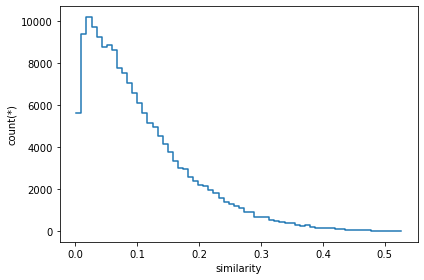

In [8]:
movie_sim.plot1d(movie_sim.similarity, limits='99.9%')

To reduce data dimension, let's take the top 30 correlated movie for each one of the 500 selected movies.

In [9]:
movie_sim_pd = movie_sim.to_pandas_df()
movie_sim_pd.sort_values(['id_left','similarity'], ascending=[True,False], inplace=True)
movie_sim_pd = movie_sim_pd.groupby('id_left').head(30)

print(movie_sim.shape)
print(movie_sim_pd.shape)

(171544, 6)
(12480, 6)


In [10]:
if not os.path.exists('output'):
    os.makedirs('output')

movie_sim_pd.to_csv('output/movie_similarity.csv', index=False)

Now, let's check to highest correlated movies:

In [11]:
movies_info = pd.read_csv('data/movie_info.csv', usecols=['id','title'])

high_sim = pd.merge(movie_sim_pd, movies_info, left_on='id_left', right_on='id')
high_sim.drop(columns=['id'], inplace=True)
high_sim.rename(columns={'title':'title_left'}, inplace=True)

high_sim = pd.merge(high_sim, movies_info, left_on='id_right', right_on='id')
high_sim.drop(columns=['id'], inplace=True)
high_sim.rename(columns={'title':'title_right'}, inplace=True)

display(high_sim[['id_left','title_left','title_right','similarity']].sort_values('similarity', ascending=False)
                                                                     .head(30))

,id_left,title_left,title_right,similarity
6500,4993,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Return of the King,0.816243
4414,7153,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Fellowship of the Ring,0.816243
3227,260,Star Wars,The Empire Strikes Back,0.753279
3393,1196,The Empire Strikes Back,Star Wars,0.753279
5055,1196,The Empire Strikes Back,Return of the Jedi,0.722074
3261,1210,Return of the Jedi,The Empire Strikes Back,0.722074
3398,1210,Return of the Jedi,Star Wars,0.702372
5031,260,Star Wars,Return of the Jedi,0.702372
7354,5418,The Bourne Identity,The Bourne Supremacy,0.692932
7190,8665,The Bourne Supremacy,The Bourne Identity,0.692932


Finally, let's test some movies:

In [12]:
display(high_sim.loc[high_sim['id_left']==4993, ['title_left','title_right','similarity']]
                .sort_values('similarity', ascending=False)
                .head(10))

,title_left,title_right,similarity
6500,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Return of the King,0.816243
3885,The Lord of the Rings: The Fellowship of the Ring,The Matrix,0.606074
3628,The Lord of the Rings: The Fellowship of the Ring,Fight Club,0.541024
721,The Lord of the Rings: The Fellowship of the Ring,Shrek,0.530268
3337,The Lord of the Rings: The Fellowship of the Ring,The Empire Strikes Back,0.525910
3441,The Lord of the Rings: The Fellowship of the Ring,Star Wars,0.502728
7708,The Lord of the Rings: The Fellowship of the Ring,The Dark Knight,0.502115
1511,The Lord of the Rings: The Fellowship of the Ring,Finding Nemo,0.491545
1050,The Lord of the Rings: The Fellowship of the Ring,"Monsters, Inc.",0.485182
7162,The Lord of the Rings: The Fellowship of the Ring,The Bourne Identity,0.471722


In [13]:
display(high_sim.loc[high_sim['id_left']==260, ['title_left','title_right','similarity']]
                .sort_values('similarity', ascending=False)
                .head(10))

,title_left,title_right,similarity
3227,Star Wars,The Empire Strikes Back,0.753279
5031,Star Wars,Return of the Jedi,0.702372
3798,Star Wars,The Matrix,0.558130
1340,Star Wars,Indiana Jones and the Last Crusade,0.530317
376,Star Wars,Back to the Future,0.507713
4341,Star Wars,The Lord of the Rings: The Fellowship of the Ring,0.502728
2412,Star Wars,The Terminator,0.496144
4222,Star Wars,Alien,0.487180
6474,Star Wars,The Lord of the Rings: The Return of the King,0.483217
2742,Star Wars,Monty Python and the Holy Grail,0.471676


In [14]:
display(high_sim.loc[high_sim['id_left']==296, ['title_left','title_right','similarity']]
                .sort_values('similarity', ascending=False)
                .head(10))

,title_left,title_right,similarity
2078,Pulp Fiction,The Silence of the Lambs,0.613286
2243,Pulp Fiction,The Shawshank Redemption,0.590023
1906,Pulp Fiction,The Usual Suspects,0.586244
3573,Pulp Fiction,Fight Club,0.557995
3458,Pulp Fiction,Reservoir Dogs,0.557944
1981,Pulp Fiction,Fargo,0.518520
3688,Pulp Fiction,American Beauty,0.517062
3799,Pulp Fiction,The Matrix,0.509230
2301,Pulp Fiction,Schindler's List,0.493973
180,Pulp Fiction,Terminator 2: Judgment Day,0.482289
